In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  Importing Libraries and Setting Up the Environment

In [3]:
!pip install einops 
!pip install torchvision 
!pip install torch 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00


In [4]:
# Import libraries and set up environment

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all warnings
import warnings
warnings.filterwarnings('ignore')

# Set environment CUDA_LAUNCH_BLOCKING=1 (for avoiding race conditions in CUDA)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display (for clearer images in notebooks)
%config InlineBackend.figure_format = 'retina'

# Import einops (rearranging tensors)
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


# Downloading and Reading the Image

--2024-09-18 15:54:44--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.156.83.58, 108.156.83.50, 108.156.83.2, ...
Connecting to segment-anything.com (segment-anything.com)|108.156.83.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: 'dog.jpg'

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.09s   

2024-09-18 15:54:44 (2.35 MB/s) - 'dog.jpg' saved [221810/221810]

torch.Size([3, 1365, 2048])


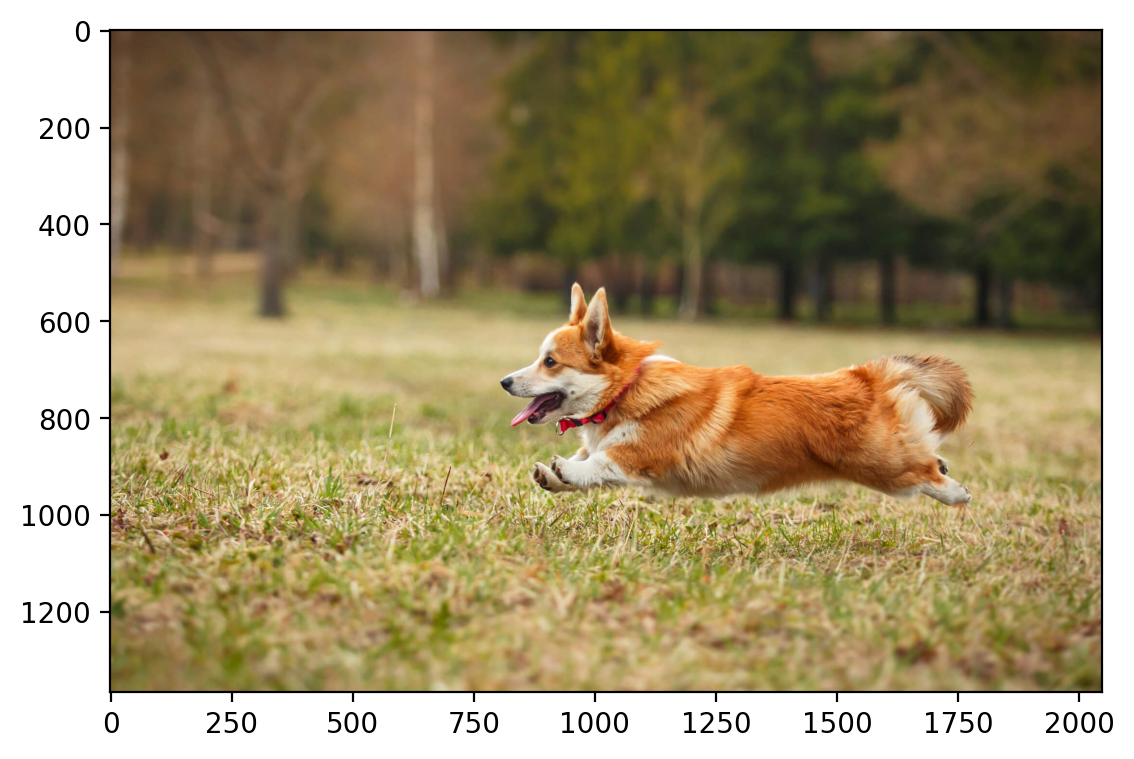

In [5]:
# Download a sample image if not already available
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Load the image into a tensor using torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)  # Check the image shape: (channels, height, width)

# Display the image using matplotlib
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


# Scaling and Transforming the Image 

In [6]:
# Scaling the image (normalize pixel values between -1 and 1 using MinMaxScaler)
from sklearn.preprocessing import MinMaxScaler
scaler_img = MinMaxScaler(feature_range=(-1, 1)).fit(img.reshape(-1, 1))

# Transform image pixel values
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

# Move the image to the appropriate device (GPU or CPU)
img_scaled = img_scaled.to(device)


# Cropping and Displaying the Image

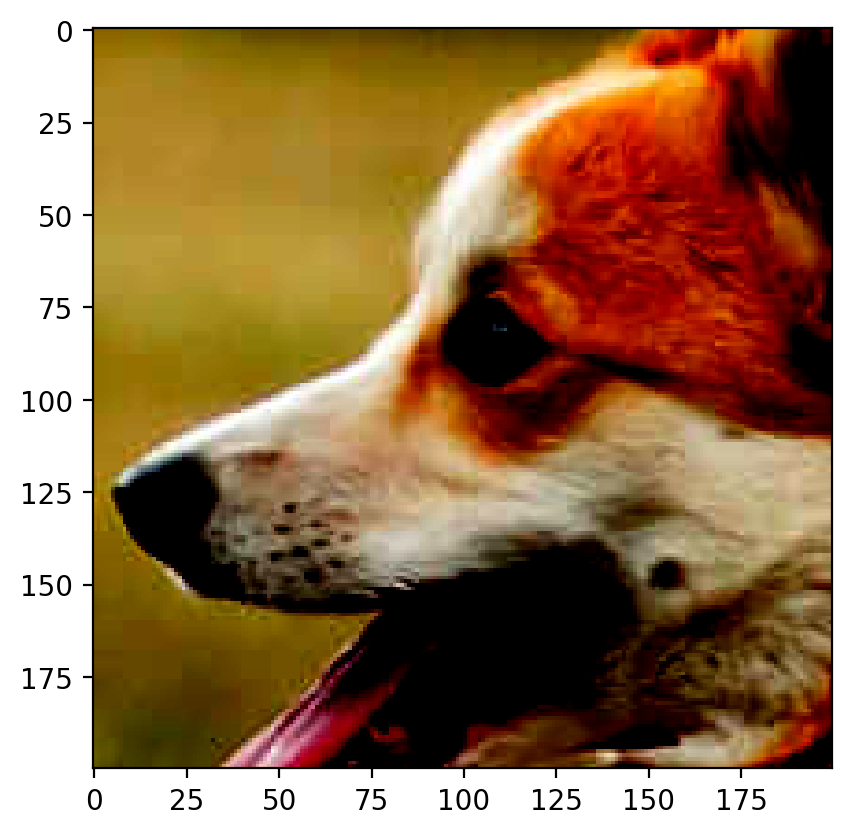

In [7]:
# Crop a section of the image (e.g., 300x300 pixels from coordinates (600, 800))
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 200, 200)
crop.shape  # Output the cropped image shape

# Display the cropped image
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


# Getting Image Dimensions and Creating Coordinate Map

In [8]:
# Get dimensions of the cropped image (num_channels, height, width)
num_channels, height, width = crop.shape
print(num_channels, height, width)  # Should output the number of color channels (3), height, and width of the image

# Function to create a coordinate map (x, y) for each pixel in the image
def create_coordinate_map(img):
    """
    Creates a 2D coordinate map for the pixels in an image.
    
    img: Input image tensor of shape (num_channels, height, width)
    
    Returns:
    X: A tensor of shape (height * width, 2) containing (x, y) coordinates
    Y: A tensor of shape (height * width, num_channels) containing pixel RGB values
    """
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x, y) coordinates
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    
    # Flatten the coordinate grids into 1D arrays
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    
    # Stack the (x, y) coordinates
    X = torch.stack([h_coords, w_coords], dim=1).float()
    X = X.to(device)  # Move the coordinates to the GPU (if available)
    
    # Reshape the image pixels into (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    
    return X, Y

# Apply the function to the cropped image
dog_X, dog_Y = create_coordinate_map(crop)
dog_X.shape, dog_Y.shape  # Output the shape of the coordinate map and pixel values


3 200 200


(torch.Size([40000, 2]), torch.Size([40000, 3]))

#  Scaling the Coordinates

In [9]:
# Import MinMaxScaler to scale coordinates to the range (-1, 1)
from sklearn import preprocessing

# Scale (X, Y) coordinates between -1 and 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled coordinates to GPU and set their data type to float32
dog_X_scaled = torch.tensor(dog_X_scaled).to(device).float()


# Defining the Linear Model

In [10]:
# Define a simple linear model for regression
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)  # Simple fully connected layer
        
    def forward(self, x):
        return self.linear(x)  # Forward pass simply applies the linear transformation


# Linear Model and Training Function

In [11]:
# Define a simple linear model to predict RGB values from (x, y) coordinates
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)  # Linear layer
    
    def forward(self, x):
        return self.linear(x)  # Forward pass through the linear layer

# Instantiate the linear model with 2 input features (x, y) and 3 output features (RGB)
net = LinearModel(2, 3)
net.to(device)  # Move model to GPU

# Define a function to train the model using Mean Squared Error (MSE) loss
def train(net, lr, X, Y, epochs, verbose=True):
    """
    Trains the linear model using Adam optimizer and MSE loss.
    
    net: torch.nn.Module
    lr: Learning rate
    X: Input coordinates (x, y)
    Y: Target pixel values (RGB)
    epochs: Number of training epochs
    """
    criterion = nn.MSELoss()  # Define loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # Adam optimizer
    
    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear gradients
        
        outputs = net(X)  # Get model predictions
        loss = criterion(outputs, Y)  # Compute loss
        
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters
        
        # Print the loss every 100 epochs
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    
    return loss.item()


# Plotting the Reconstructed Image

In [12]:
# Function to plot both the original and reconstructed images
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    Plots the original and reconstructed images side by side.
    
    original_img: Original image tensor
    net: Trained neural network model
    X: Input coordinates (x, y)
    title: Plot title
    """
    num_channels, height, width = original_img.shape
    
    # Set model to evaluation mode and disable gradient computation
    net.eval()
    with torch.no_grad():
        outputs = net(X)  # Get model predictions
        outputs = outputs.reshape(height, width, num_channels)
    
    # Plot the images
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Reconstructed image
    ax0 = plt.subplot(gs[0])
    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    
    # Original image
    ax1 = plt.subplot(gs[1])
    ax1.imshow(original_img.cpu().permute(1, 2, 0))  # Adjust dimensions for plotting
    ax1.set_title("Original Image")
    
    # Remove axes for both images
    for a in [ax0, ax1]:
        a.axis("off")
    
    # Add title to the figure
    fig.suptitle(title, y=0.9)
    plt.tight_layout()


#  Random Fourier Features (RFF)

Epoch 0 loss: 0.654774
Epoch 100 loss: 0.256004
Epoch 200 loss: 0.161087
Epoch 300 loss: 0.141387
Epoch 400 loss: 0.138596
Epoch 500 loss: 0.138348
Epoch 600 loss: 0.138335
Epoch 700 loss: 0.138334
Epoch 800 loss: 0.138334
Epoch 900 loss: 0.138334
Epoch 1000 loss: 0.138334
Epoch 1100 loss: 0.138334
Epoch 1200 loss: 0.138334
Epoch 1300 loss: 0.138334
Epoch 1400 loss: 0.138334


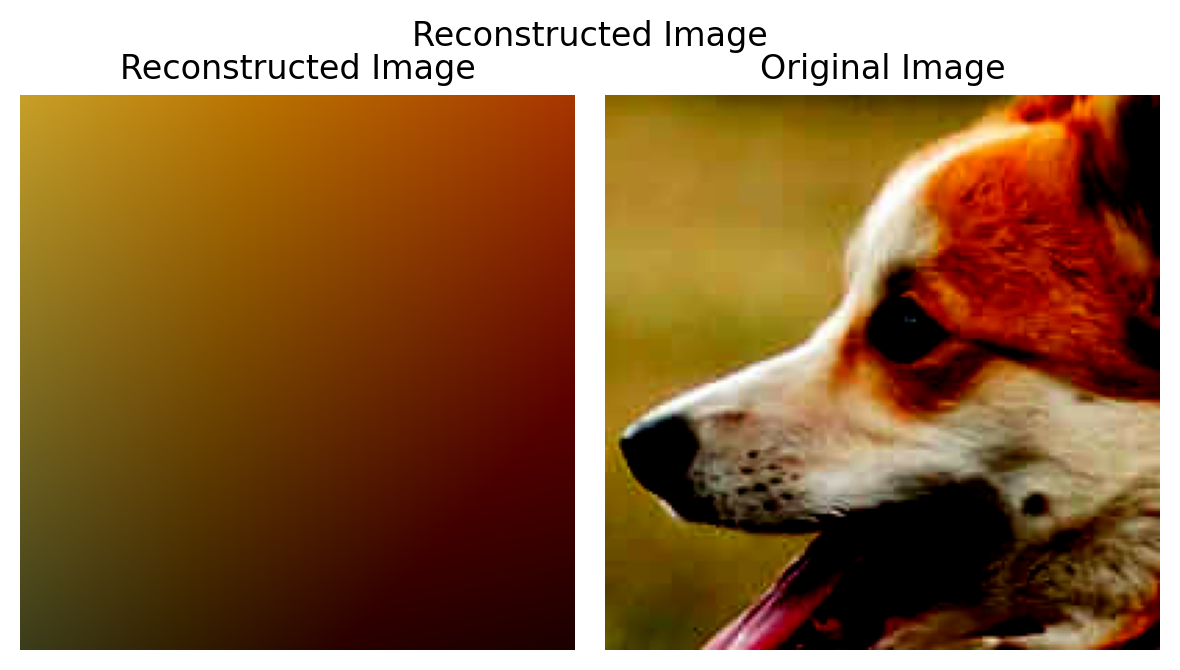

In [13]:
# Initialize the linear model with 2 input features and 3 output features (RGB)
net = LinearModel(2, 3).to(device)

# Train the model with learning rate 0.005 for 1500 epochs# Function to create Random Fourier Features (RFF)
def create_rff_features(X, num_features, sigma):
    """
    Create Random Fourier Features (RFF) from the input coordinates.
    
    X: Input coordinates (x, y)
    num_features: Number of RFF features
    sigma: Standard deviation for the RBF kernel
    """
    from sklearn.kernel_approximation import RBFSampler
    
    # Create RBF sampler with n_components = num_features and gamma = 1 / (2 * sigma^2)
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma**2))
    
    # Apply the RFF transformation to the input coordinates
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    
    # Convert the result back to a tensor and return it
    return torch.tensor(X, dtype=torch.float32).to(device)

# Apply RFF transformation to the scaled coordinates
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

train(net, lr=0.005, X=dog_X_scaled.to(device), Y=dog_Y.to(device), epochs=1500)

# Plot the reconstructed image and the original image
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")


#  Training the Model with RFF Features

Epoch 0 loss: 0.243533
Epoch 100 loss: 0.093119
Epoch 200 loss: 0.063921
Epoch 300 loss: 0.046305
Epoch 400 loss: 0.033807
Epoch 500 loss: 0.024580
Epoch 600 loss: 0.017720
Epoch 700 loss: 0.012646
Epoch 800 loss: 0.008930
Epoch 900 loss: 0.006239
Epoch 1000 loss: 0.004314
Epoch 1100 loss: 0.002955
Epoch 1200 loss: 0.002010
Epoch 1300 loss: 0.001363
Epoch 1400 loss: 0.000928
Epoch 1500 loss: 0.000641
Epoch 1600 loss: 0.000456
Epoch 1700 loss: 0.000339
Epoch 1800 loss: 0.000266
Epoch 1900 loss: 0.000222
Epoch 2000 loss: 0.000196
Epoch 2100 loss: 0.000180
Epoch 2200 loss: 0.000170
Epoch 2300 loss: 0.000164
Epoch 2400 loss: 0.000160


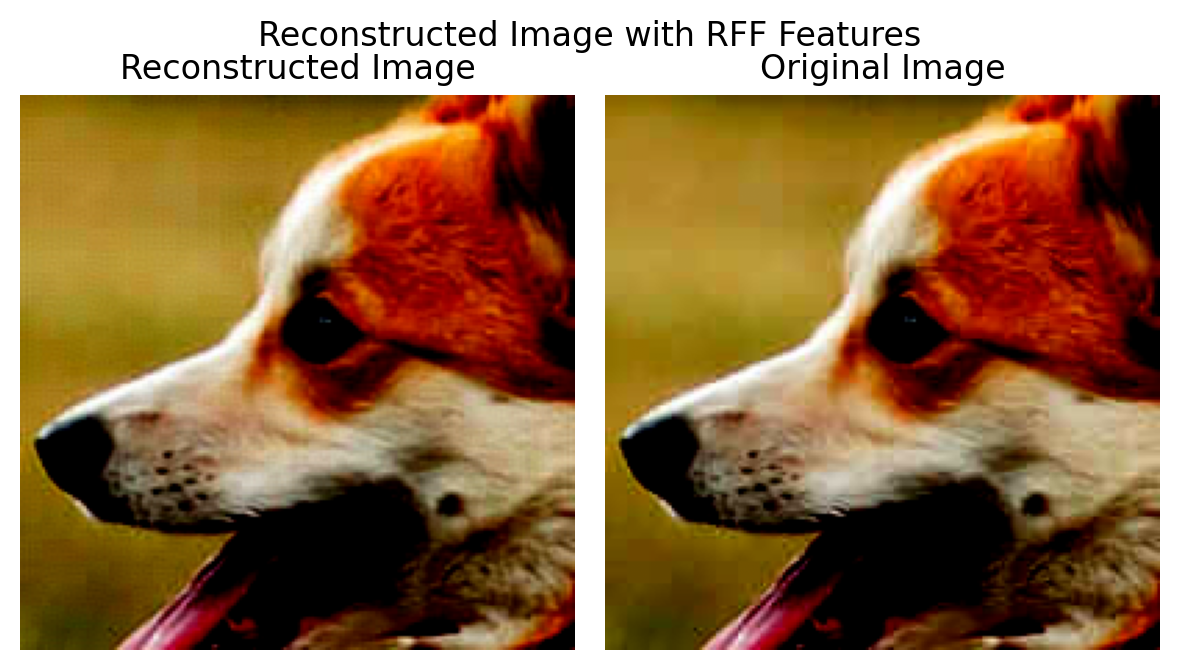

In [14]:
# Define and train a new model using RFF features as input
net = LinearModel(X_rff.shape[1], 3)  # Input size = number of RFF features
net.to(device)  # Move model to GPU

# Train the model using the RFF features
train(net, 0.005, X_rff.to(device), dog_Y.to(device), 2500)

# Plot the original and reconstructed images using RFF features
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")


# The Change in RMSE and PSNR
---
RMSE is Root Mean Square Error
---
PNSR is the Peak Signal to Noise Ratio
---

In [15]:
import numpy as np
import torch
from sklearn.kernel_approximation import RBFSampler

# Function to compute RMSE
def rmse(y, y_hat):
    """
    Compute Root Mean Squared Error (RMSE).
    
    y: Ground truth values
    y_hat: Predicted values
    """
    return np.sqrt(np.mean((y - y_hat) ** 2))

# Function to compute PSNR
def psnr(y, y_hat):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR).
    
    y: Ground truth values
    y_hat: Predicted values
    """
    rmse_value = rmse(y, y_hat)
    if rmse_value == 0:
        return np.inf
    else:
        return 20 * np.log10(1 / rmse_value)


# Loop to vary the number of RFF features and calculate RMSE and PSNR
results = []
for i in range(1000, 40000, 1000):
    print(f"Number of RFF features: {i}")
    
    # Apply RFF transformation to the input data
    X_rff = create_rff_features(dog_X_scaled, i, 0.008)
    
    # Define and train the model with the current number of RFF features
    net = LinearModel(X_rff.shape[1], 3).to(device)
    train(net, lr=0.005, X=X_rff.to(device), Y=dog_Y.to(device), epochs=1500)
    
    # Get reconstructed image
    reconstructed_image = net(X_rff).detach().cpu().numpy()
    
    # Calculate RMSE and PSNR between the original and reconstructed images
    y_true = dog_Y.cpu().numpy()  # Original image
    y_pred = reconstructed_image  # Reconstructed image
    current_rmse = rmse(y_true, y_pred)
    current_psnr = psnr(y_true, y_pred)
    
    # Store the results
    results.append((i, current_rmse, current_psnr))
    print(f"RMSE: {current_rmse}, PSNR: {current_psnr}")

Number of RFF features: 1000
Epoch 0 loss: 0.248844
Epoch 100 loss: 0.150688
Epoch 200 loss: 0.141769
Epoch 300 loss: 0.137175
Epoch 400 loss: 0.133574
Epoch 500 loss: 0.130716
Epoch 600 loss: 0.128449
Epoch 700 loss: 0.126657
Epoch 800 loss: 0.125242
Epoch 900 loss: 0.124126
Epoch 1000 loss: 0.123248
Epoch 1100 loss: 0.122559
Epoch 1200 loss: 0.122021
Epoch 1300 loss: 0.121605
Epoch 1400 loss: 0.121285
RMSE: 0.3479101359844208, PSNR: 9.170658367389228
Number of RFF features: 2000
Epoch 0 loss: 0.243664
Epoch 100 loss: 0.144921
Epoch 200 loss: 0.136217
Epoch 300 loss: 0.131549
Epoch 400 loss: 0.128018
Epoch 500 loss: 0.125218
Epoch 600 loss: 0.122927
Epoch 700 loss: 0.121003
Epoch 800 loss: 0.119354
Epoch 900 loss: 0.117919
Epoch 1000 loss: 0.116660
Epoch 1100 loss: 0.115548
Epoch 1200 loss: 0.114565
Epoch 1300 loss: 0.113696
Epoch 1400 loss: 0.112928
RMSE: 0.3350367546081543, PSNR: 9.498150936999522
Number of RFF features: 3000
Epoch 0 loss: 0.247051
Epoch 100 loss: 0.143869
Epoch 200

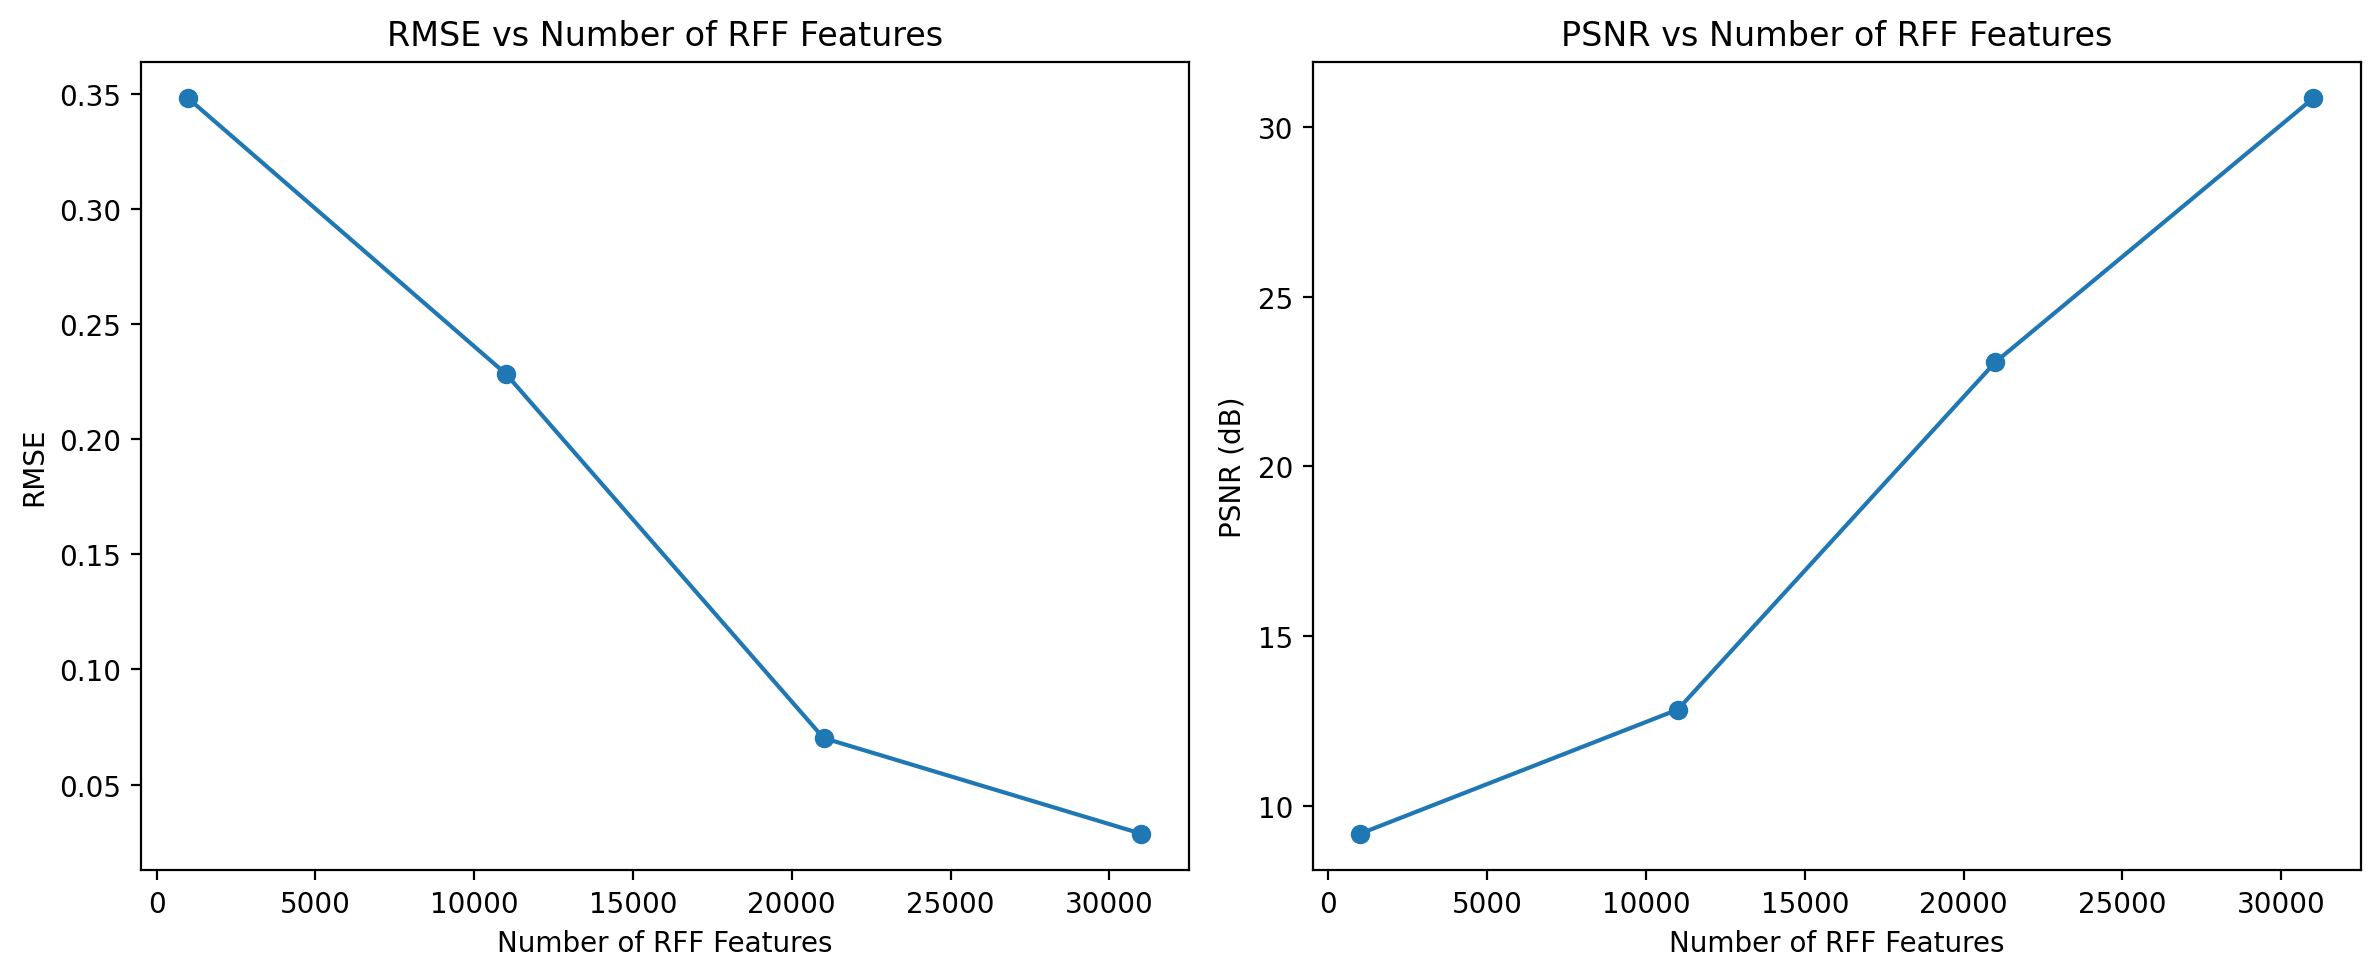

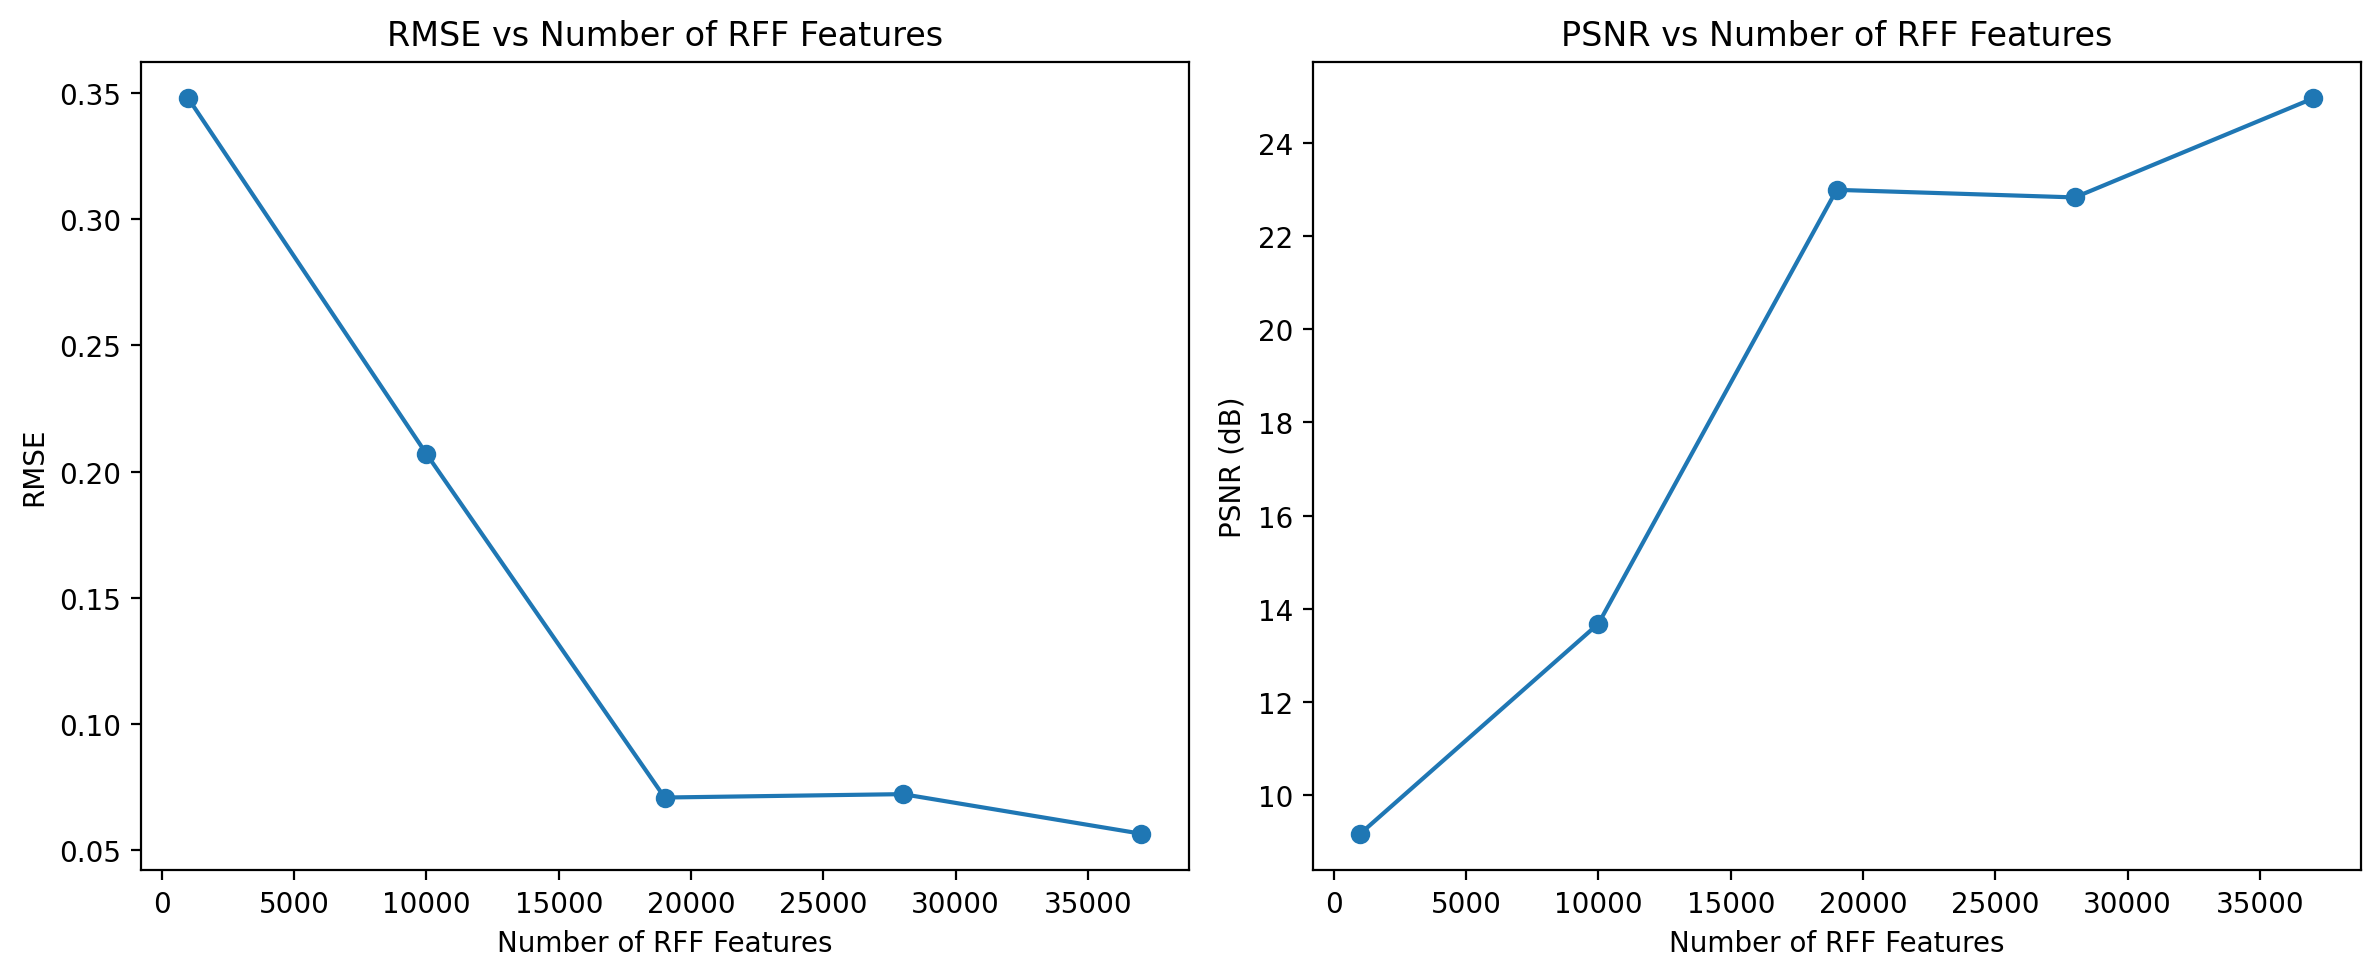

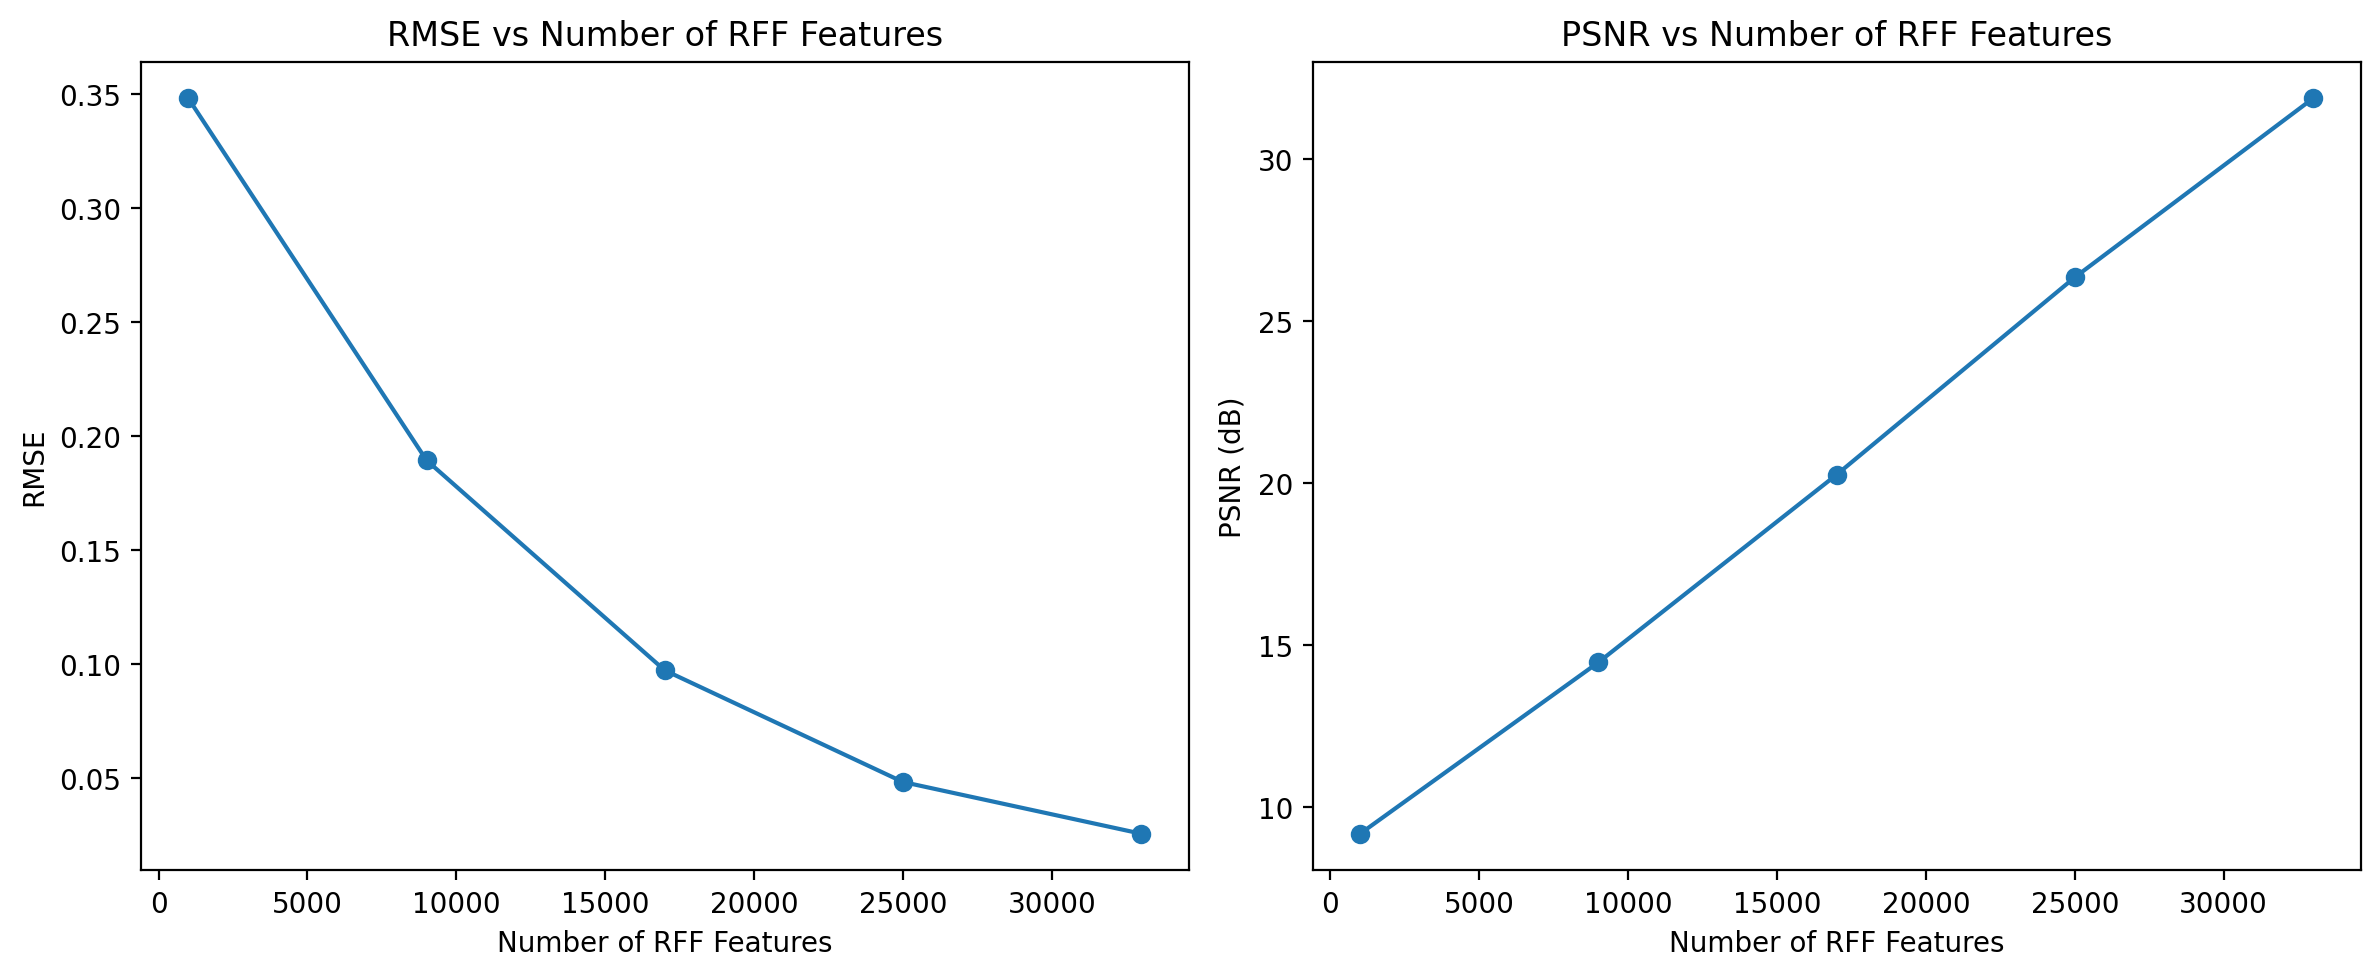

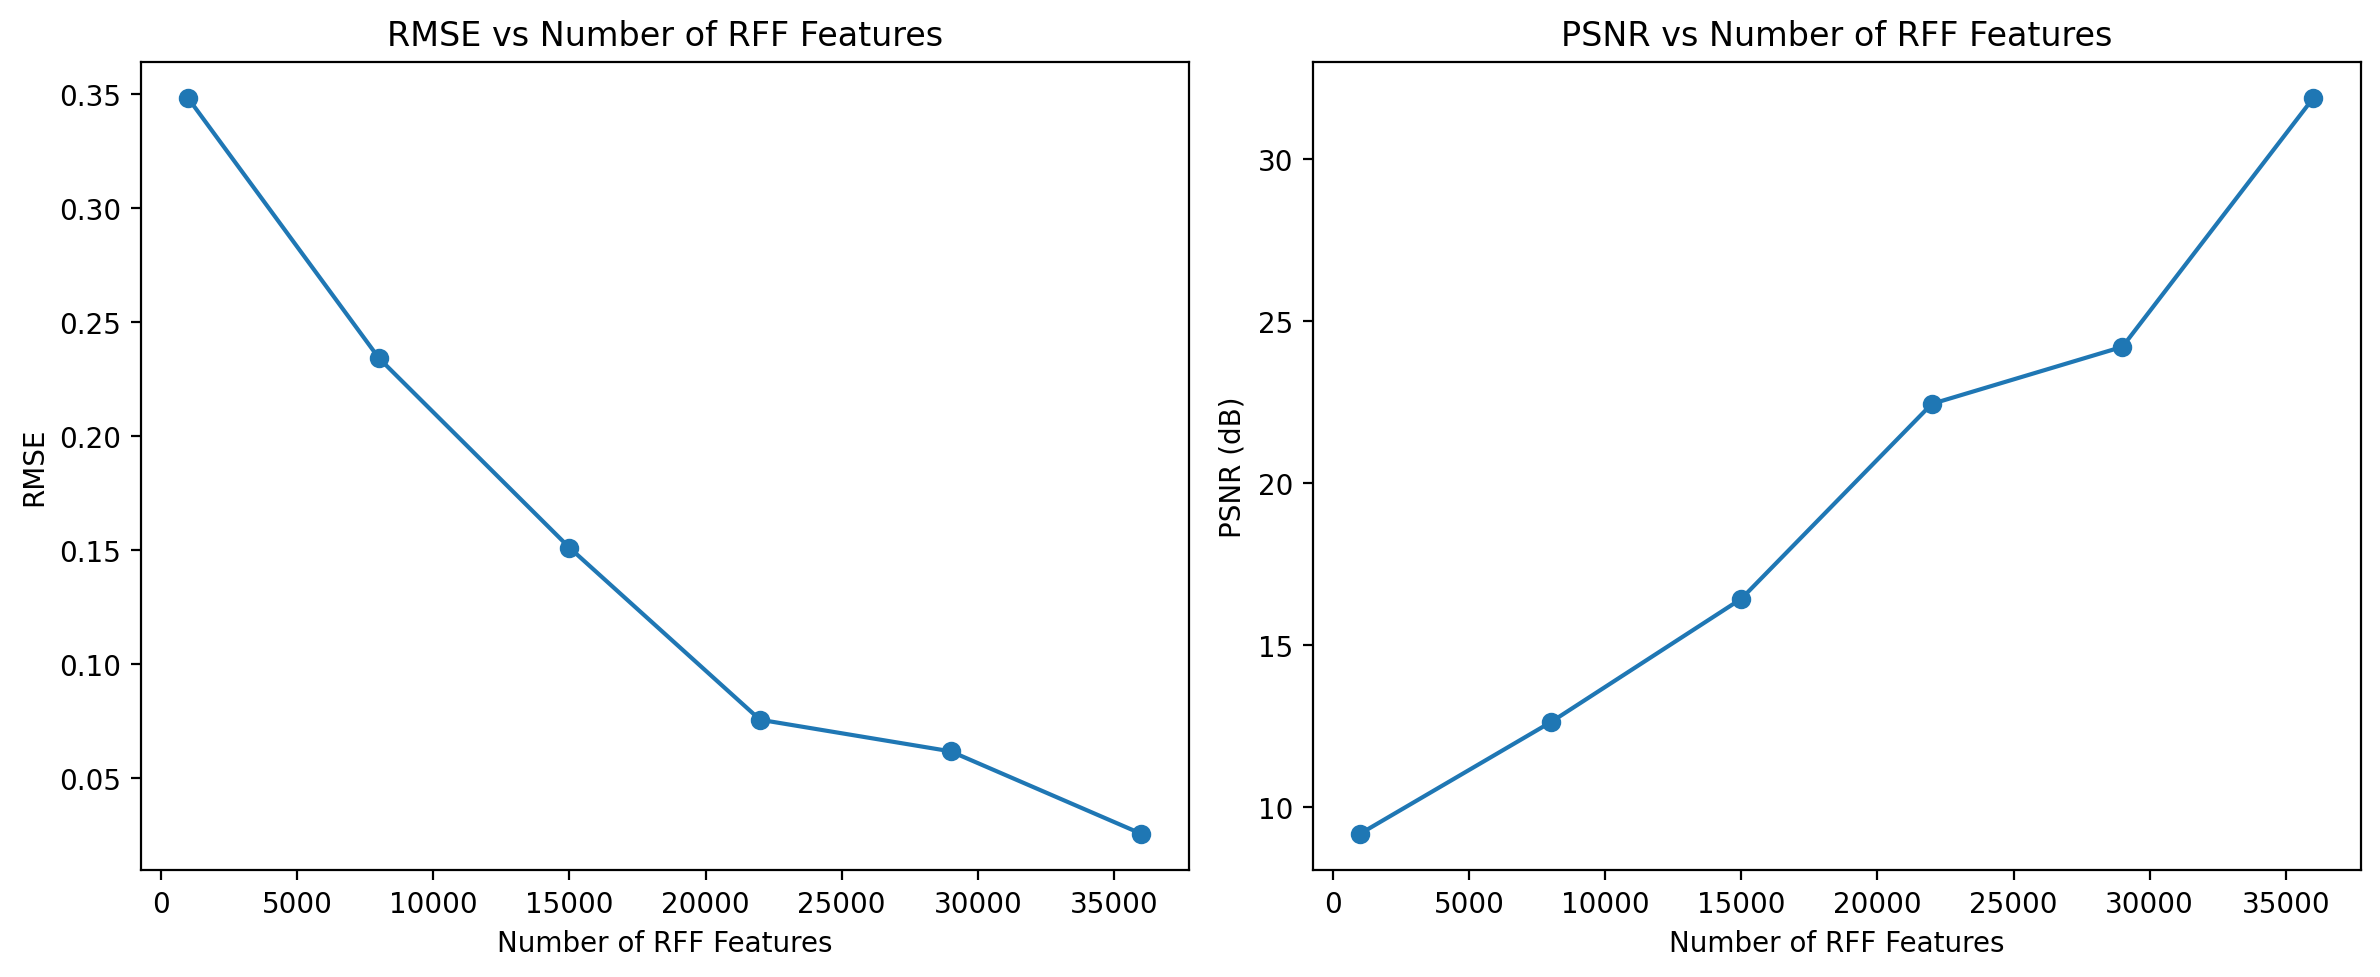

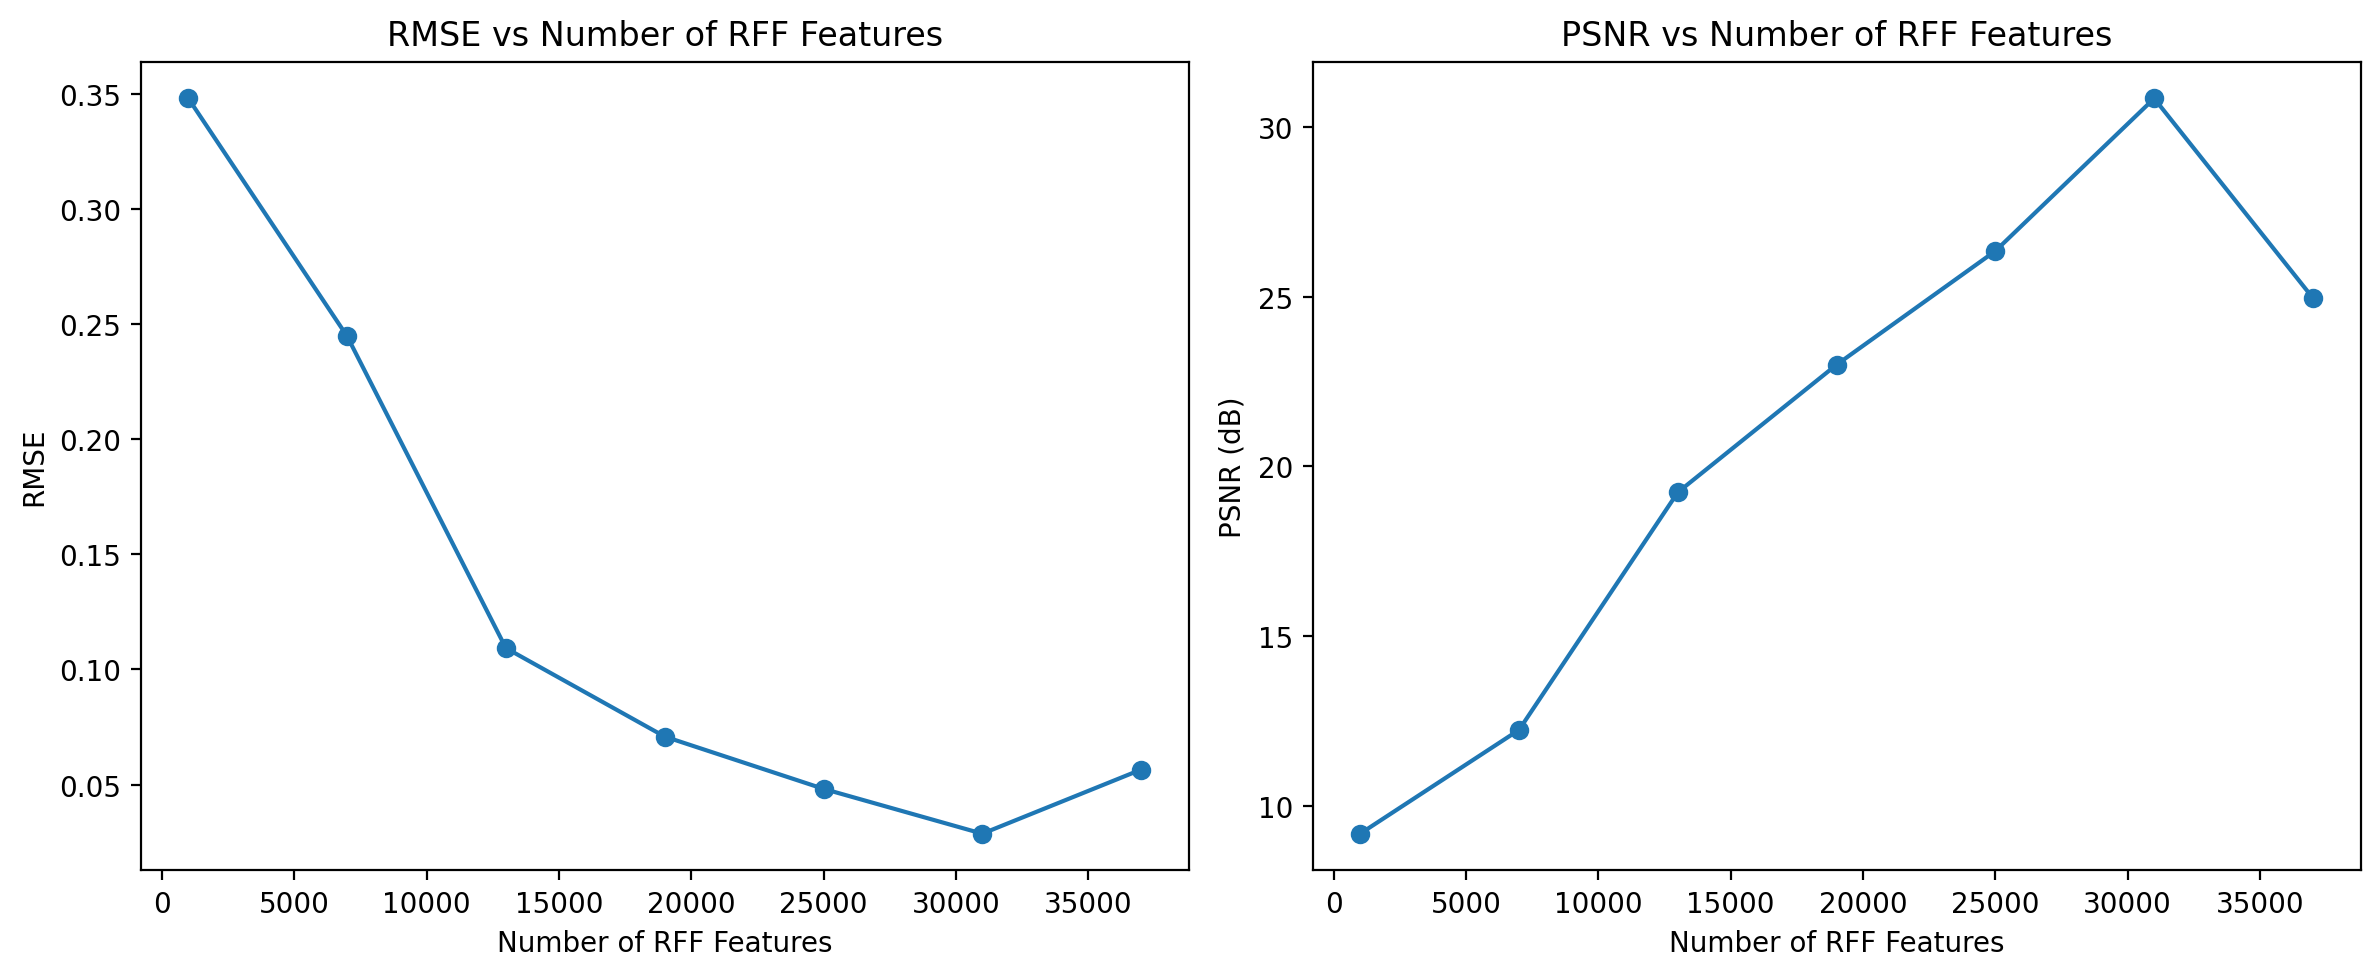

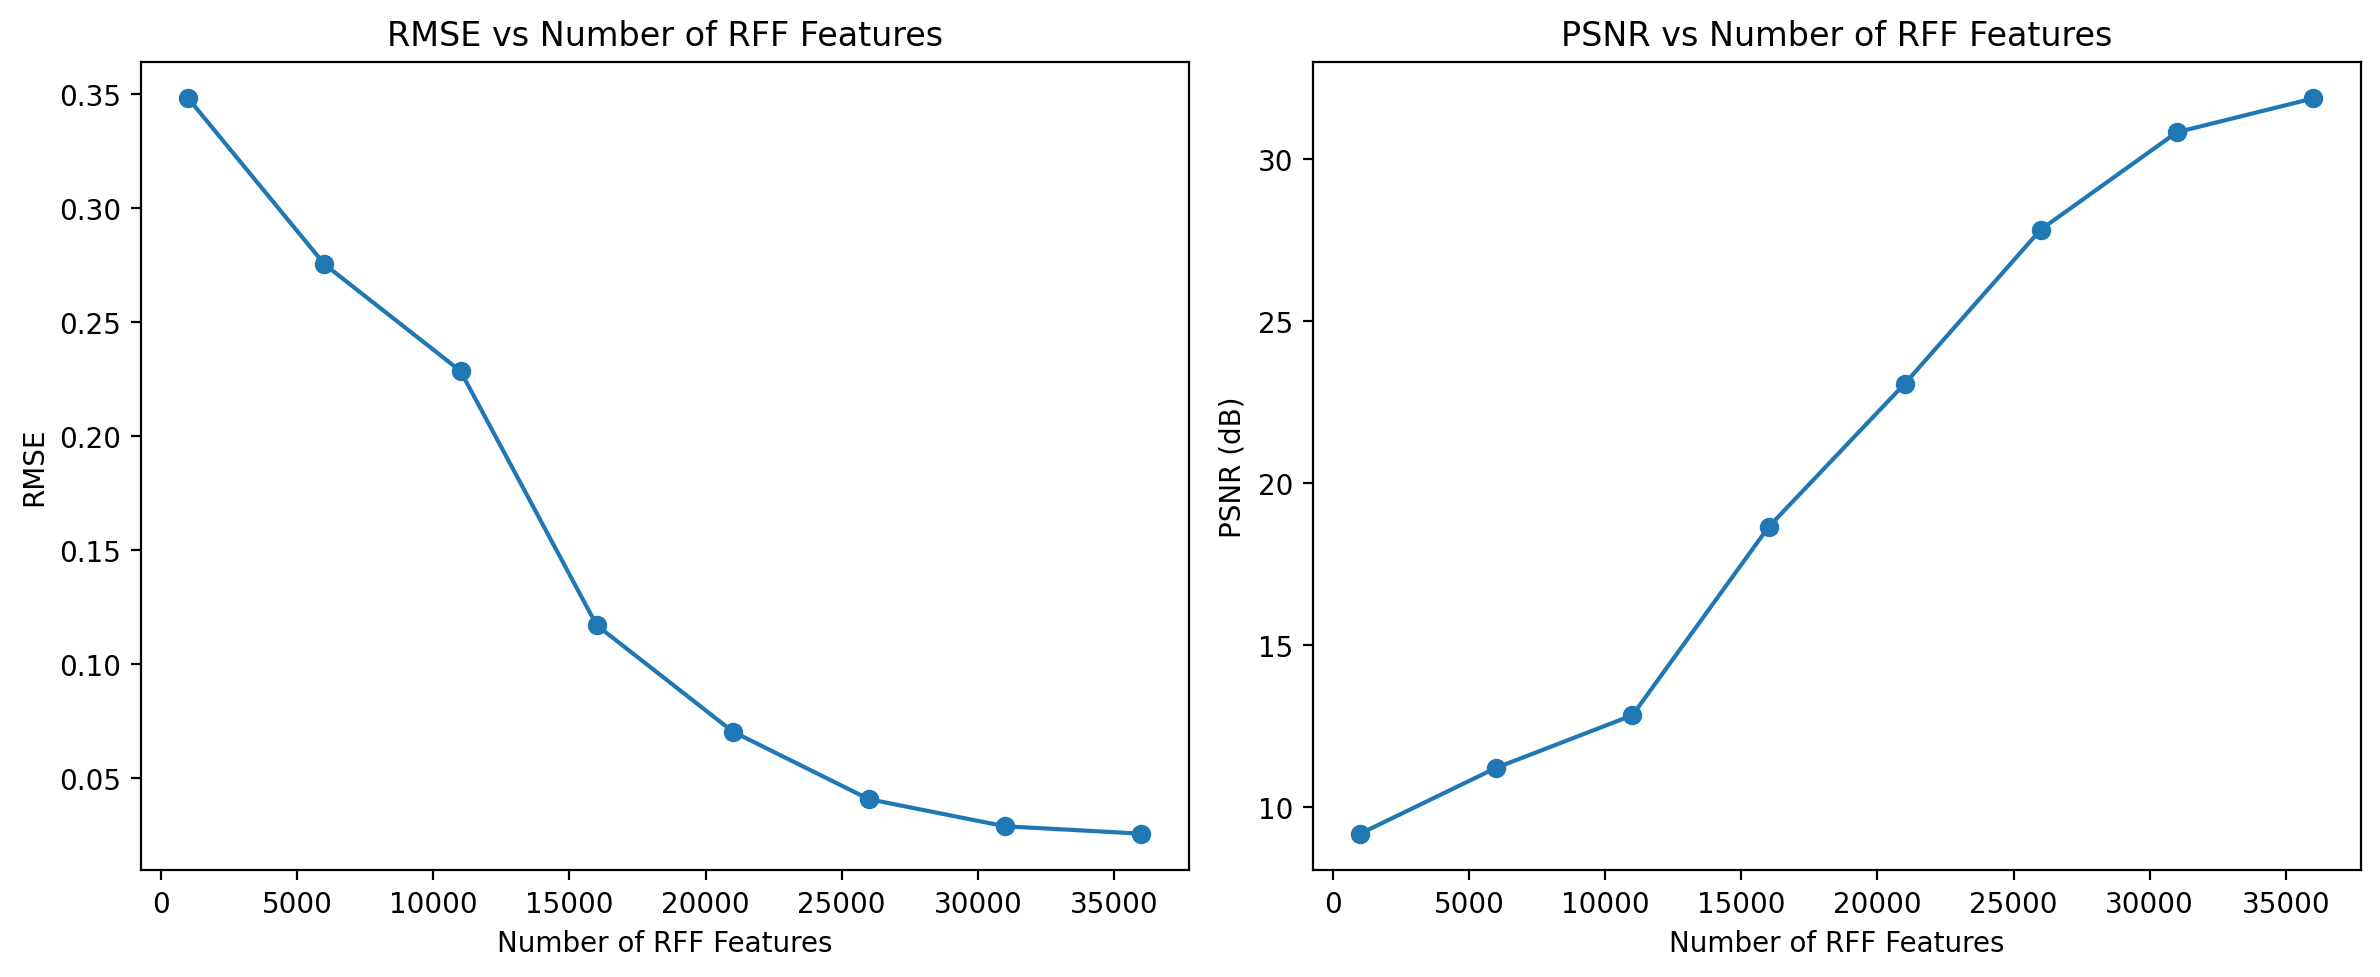

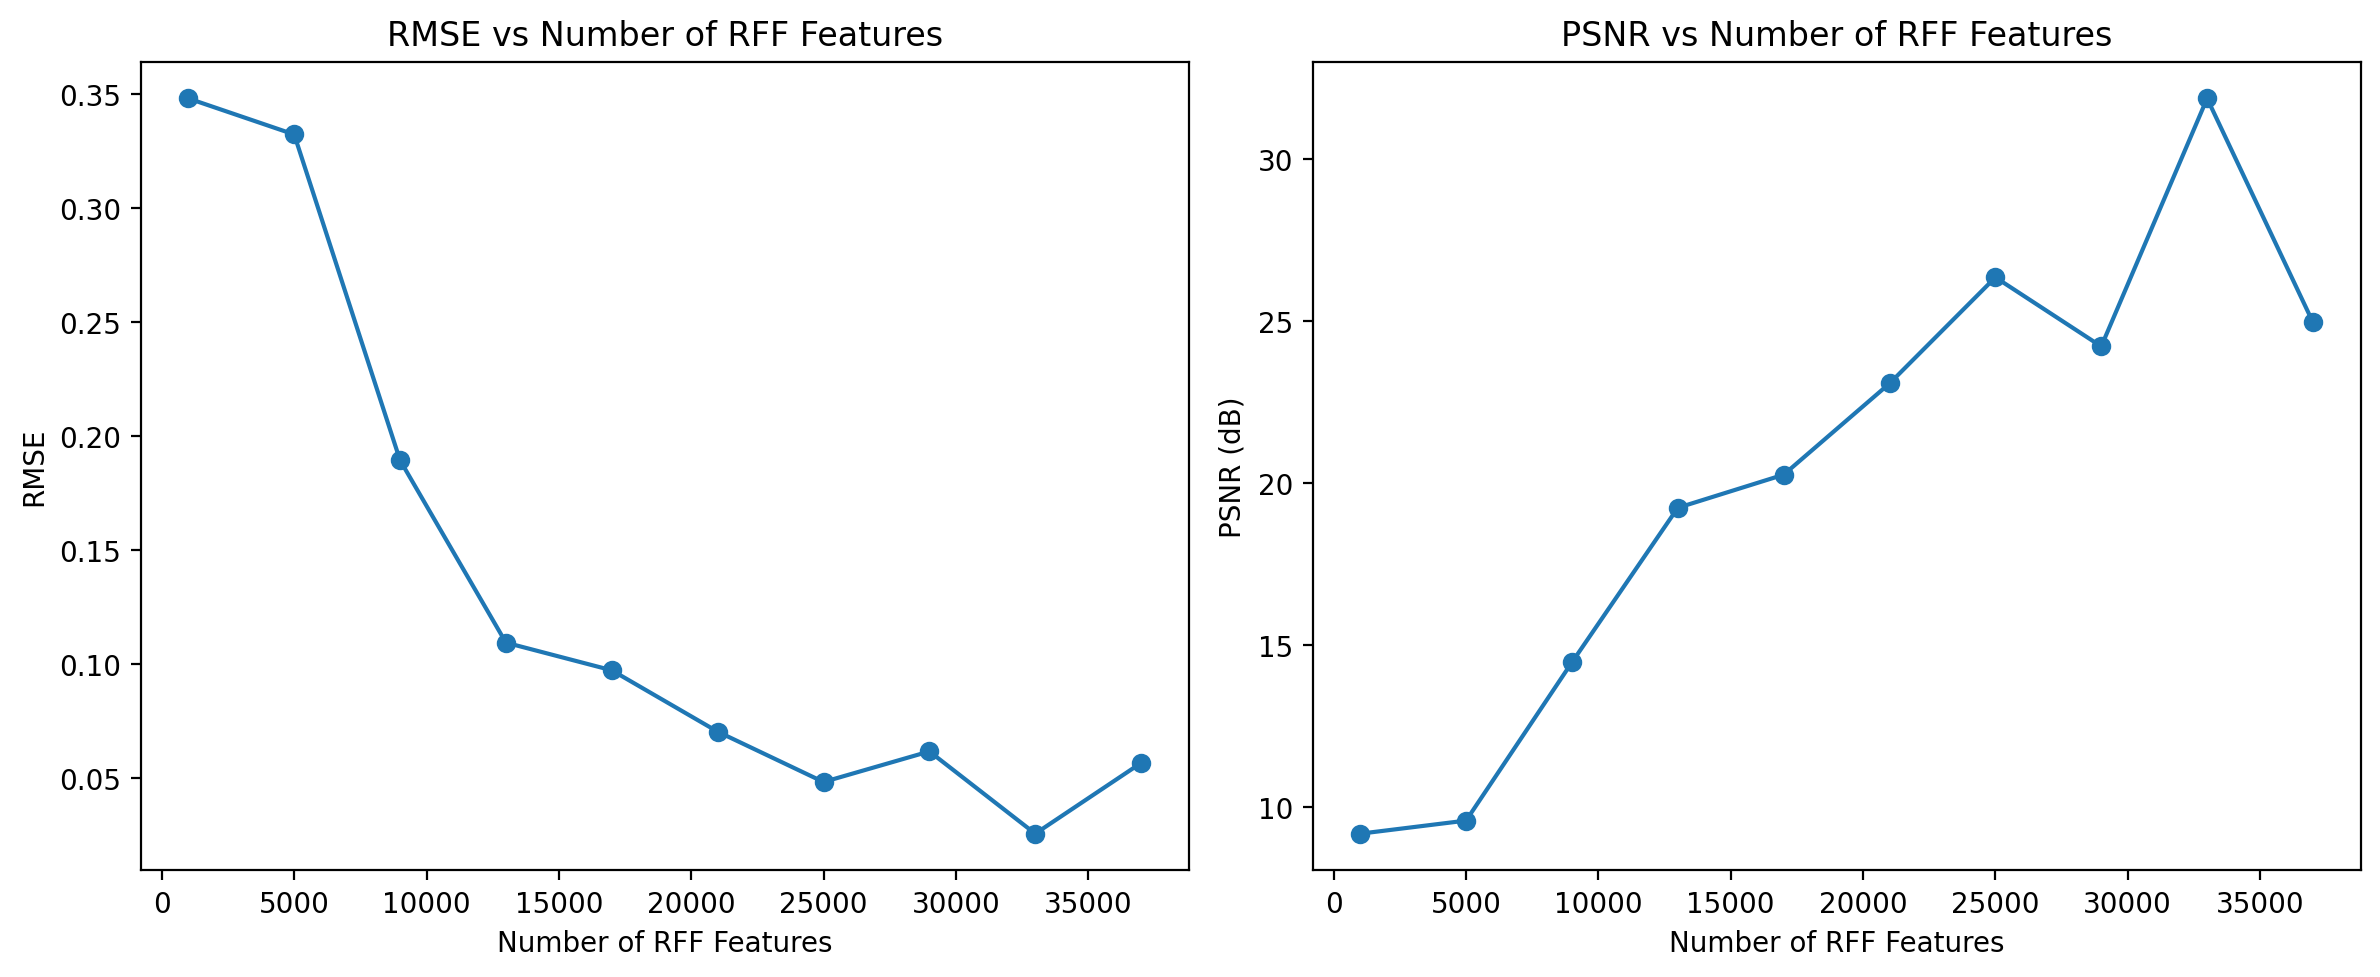

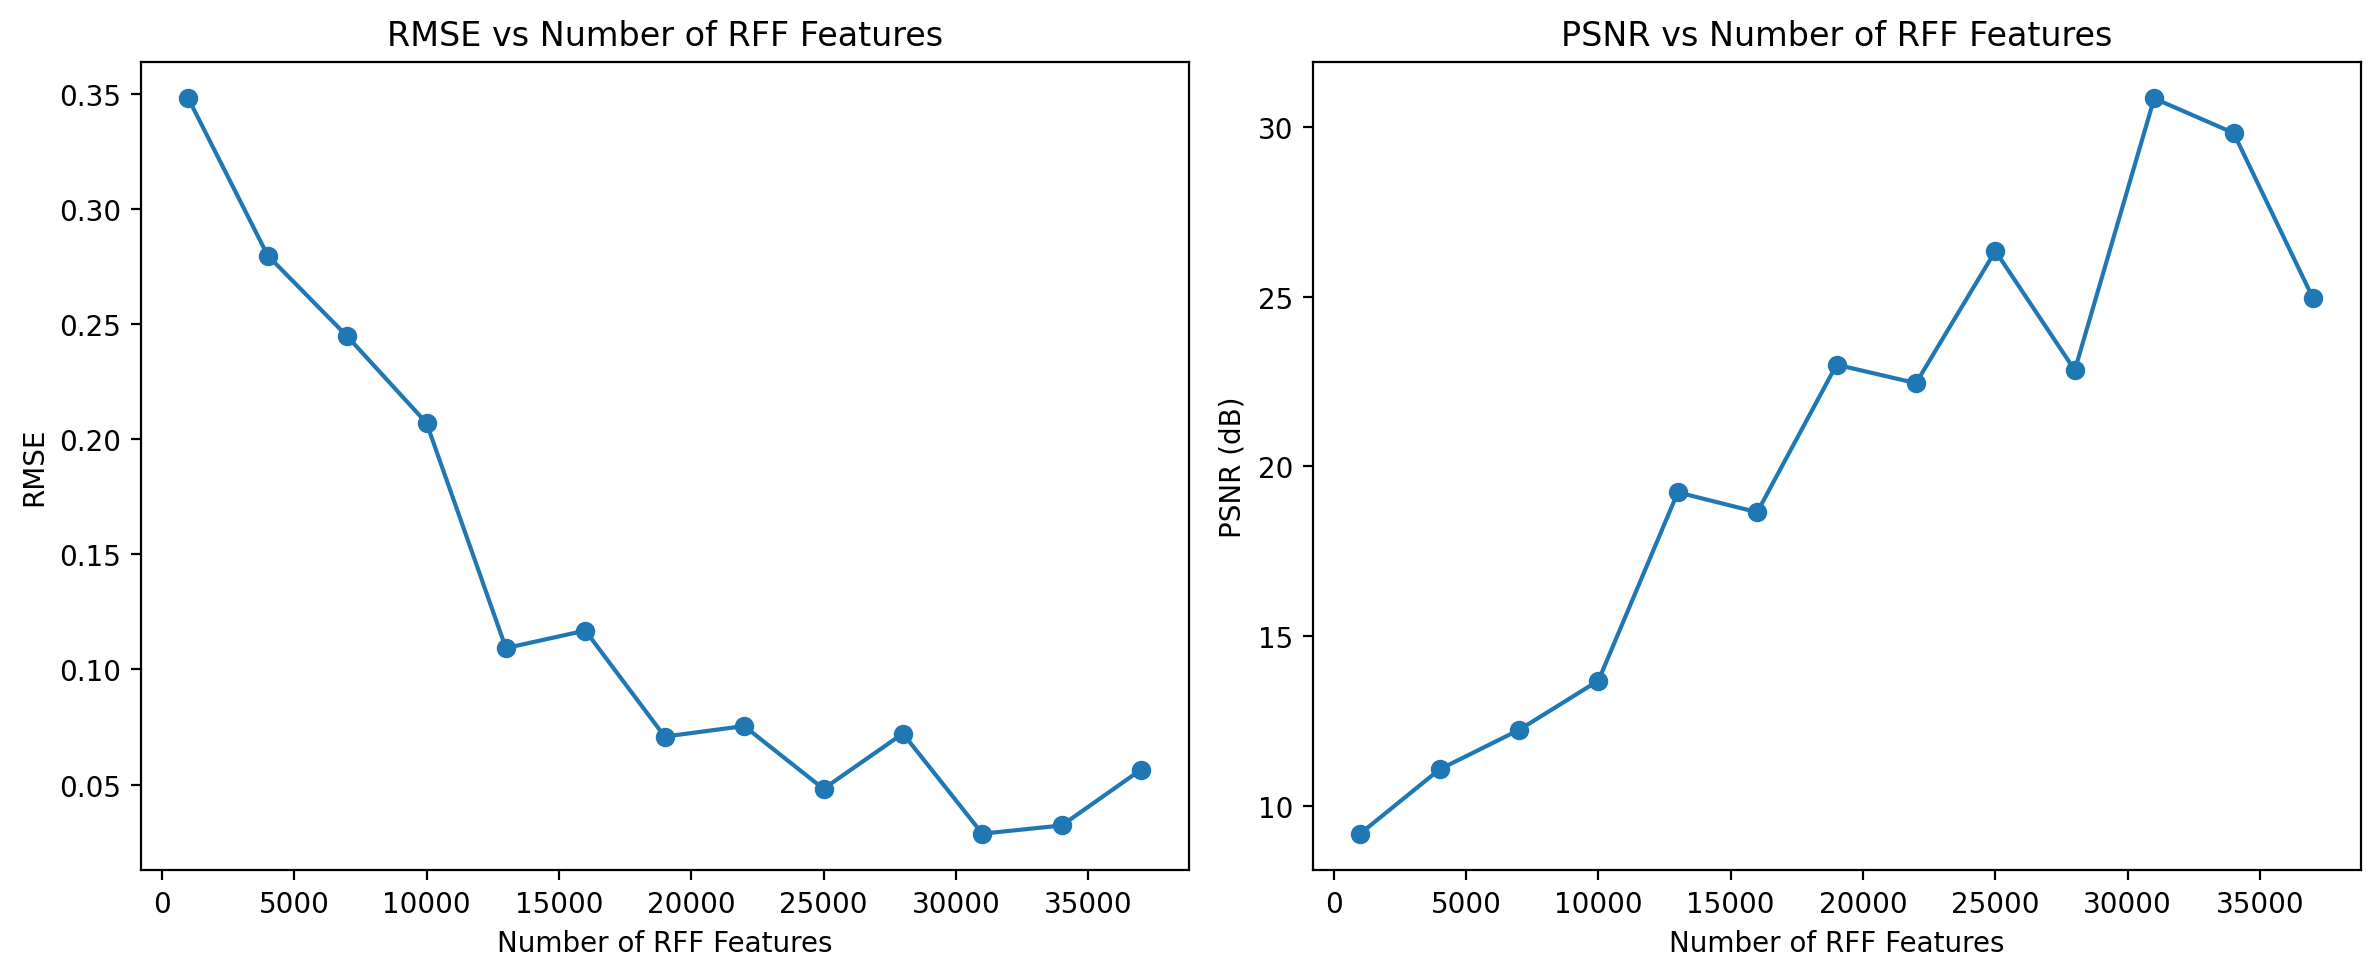

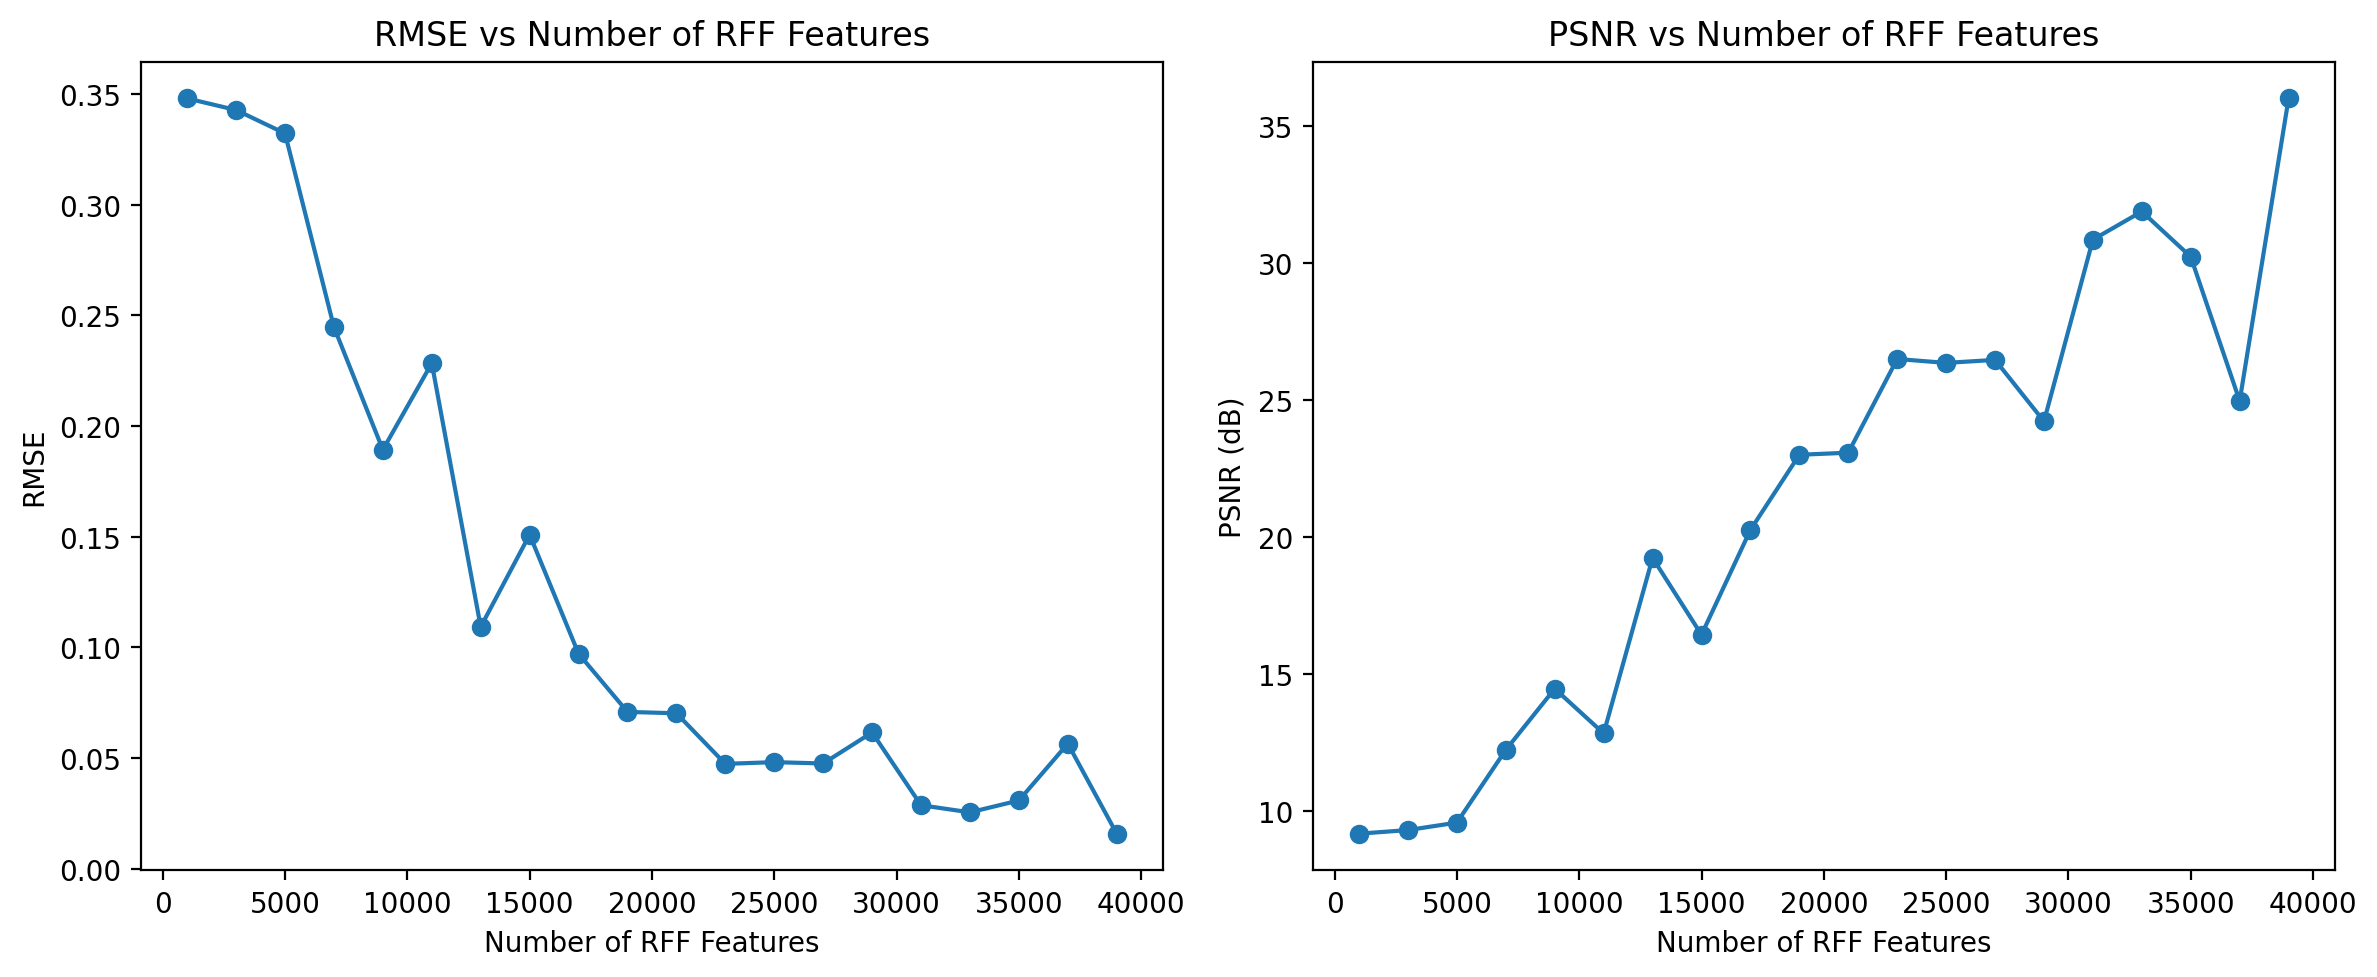

In [16]:
import matplotlib.pyplot as plt

# Unpack results
features, rmse_values, psnr_values = zip(*results)

for n in range(10,1,-1):
    # Plot RMSE vs number of RFF features
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(features[::n], rmse_values[::n], marker='o')
    plt.title("RMSE vs Number of RFF Features")
    plt.xlabel("Number of RFF Features")
    plt.ylabel("RMSE")

    # Plot PSNR vs number of RFF features
    plt.subplot(1, 2, 2)
    plt.plot(features[::n], psnr_values[::n], marker='o')
    plt.title("PSNR vs Number of RFF Features")
    plt.xlabel("Number of RFF Features")
    plt.ylabel("PSNR (dB)")

    plt.tight_layout()
    plt.show()

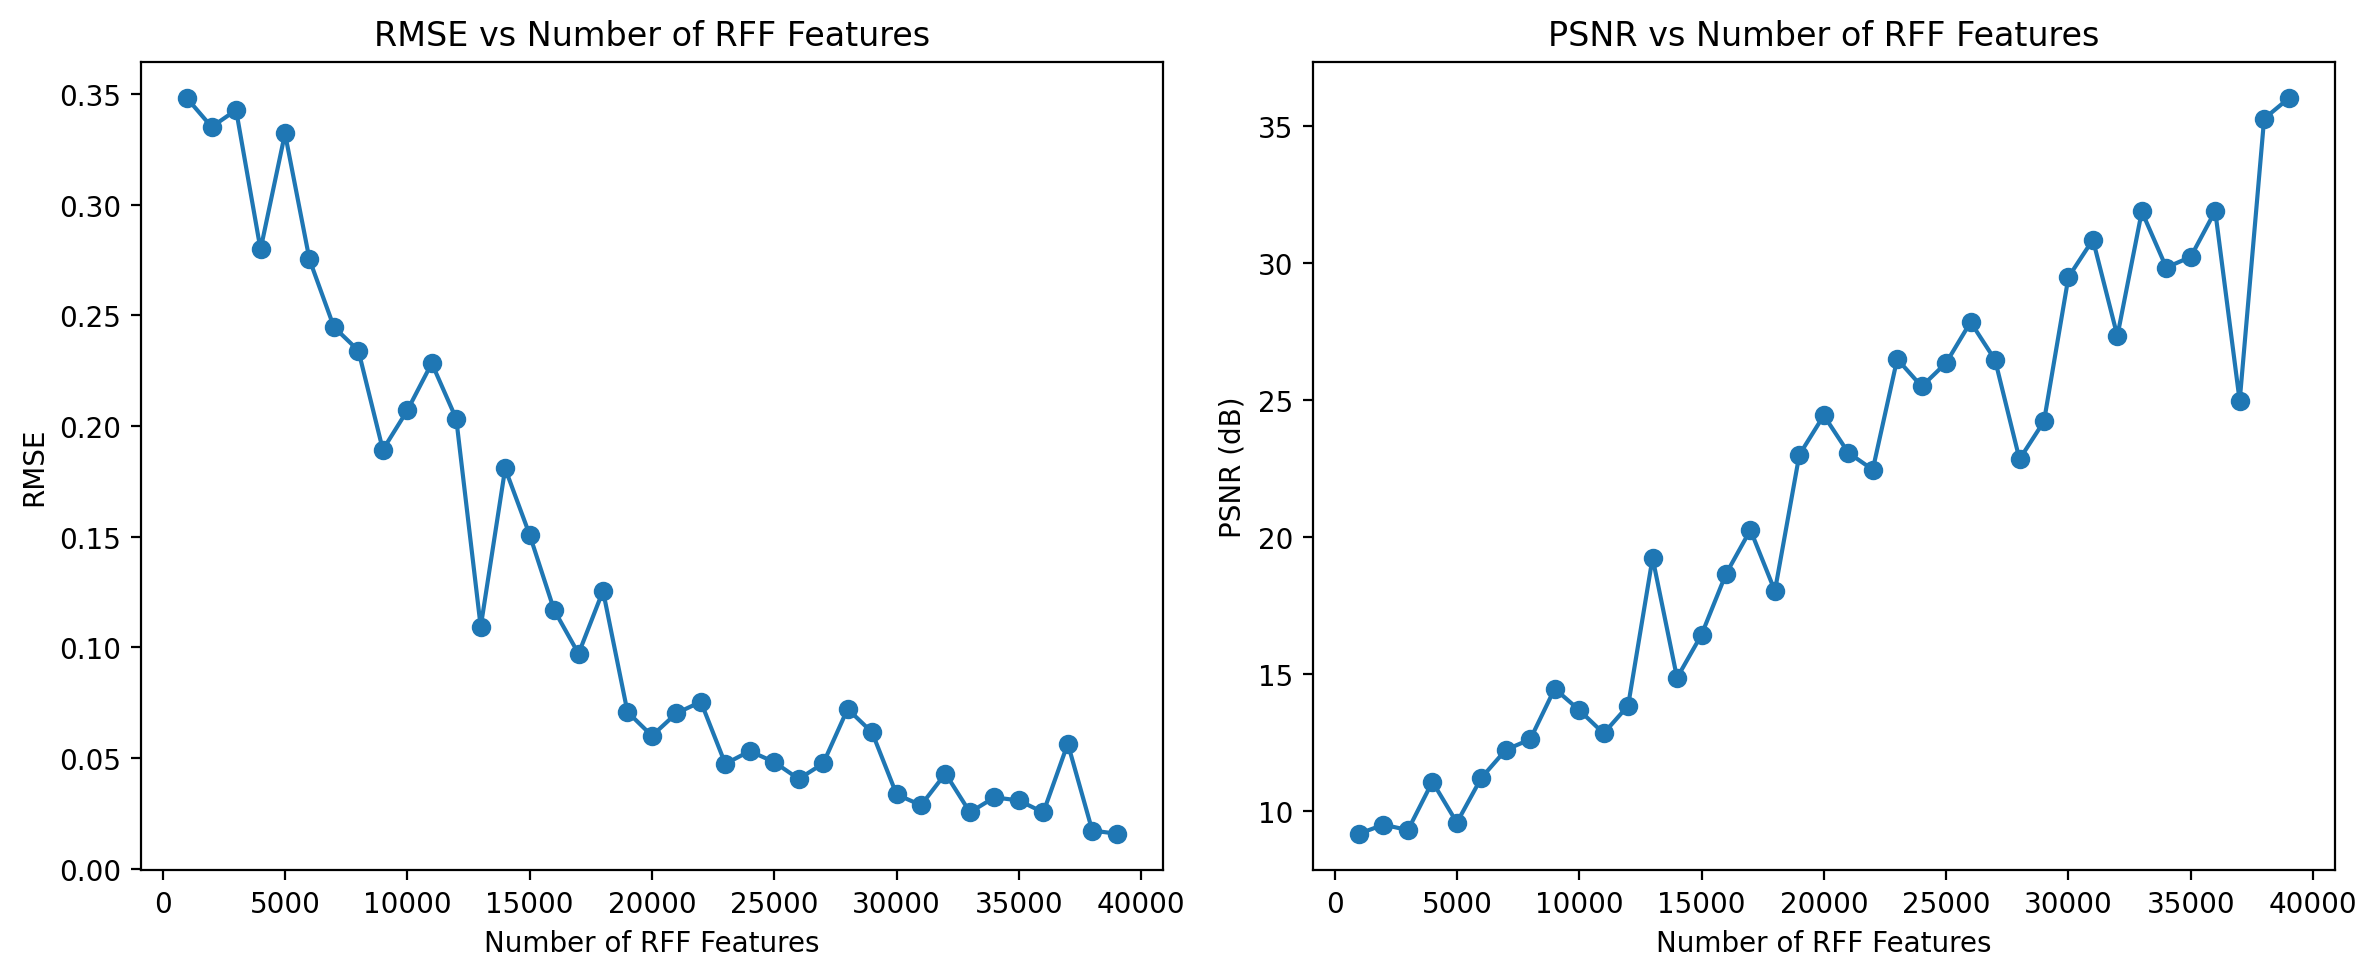

In [17]:
import matplotlib.pyplot as plt

# Unpack results
features, rmse_values, psnr_values = zip(*results)

# Plot RMSE vs number of RFF features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(features, rmse_values, marker='o')
plt.title("RMSE vs Number of RFF Features")
plt.xlabel("Number of RFF Features")
plt.ylabel("RMSE")

# Plot PSNR vs number of RFF features
plt.subplot(1, 2, 2)
plt.plot(features, psnr_values, marker='o')
plt.title("PSNR vs Number of RFF Features")
plt.xlabel("Number of RFF Features")
plt.ylabel("PSNR (dB)")

plt.tight_layout()
plt.show()